<br>

<div align=center><font color=maroon size=6><b>Transfer Learning for Computer Vision Tutorial</b></font></div>

<br>

<font size=4><b>References:</b></font>
1. Pytorch official tutorials: <a href="https://pytorch.org/tutorials/index.html" style="text-decoration:none;">WELCOME TO PYTORCH TUTORIALS</a> 
    * Tutorials > <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html" style="text-decoration:none;">Transfer Learning for Computer Vision Tutorial</a>
    * Docs > <a href="" style="text-decoration:none;"></a>

<br>
<br>
<br>

**Author:** <a href="https://chsasank.github.io/" style="text-decoration:none;color:maroon;font-size:120%;">Sasank Chilamkurthy</a>

<br>
<br>

In this tutorial, you will learn how to train a convolutional neural network for image classification using transfer learning. You can read more about the transfer learning at <a href="https://cs231n.github.io/transfer-learning/" style="text-decoration:none;color:maroon;font-size:120%;">cs231n notes</a>

<font size=3>Quoting these notes,<br>
<font color=maroon>
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ***ImageNet***, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an **initialization** or a **fixed feature extractor** for the task of interest.</font></font>


<br>

<font size=3>These two major transfer learning scenarios look as follows:

* <font color=maroon>**Finetuning the convnet**</font>: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.


* <font color=maroon>**ConvNet as fixed feature extractor**</font>: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.</font>


<br>

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import transforms, datasets, models   # datasets.ImageFolder()
# from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import matplotlib.pyplot as plt


cudnn.benchmark = True
plt.ion()    # interactive mode

<br>
<br>
<br>

# Load Data <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#load-data" style="text-decoration:none;font-size:70%">[link]</a>

<font size=3>We will use `torchvision` and `torch.utils.data` packages for loading the data.</font>


The problem we’re going to solve today is to train a model to classify **ants** and **bees**. We have about 120 training images each for ants and bees. There are 75 validation images for each class. <font color=maroon size=3>Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.</font>

This dataset is a very small subset of imagenet.

<div class="alert alert-block alert-info">

<font size=3 color=red><b>NOTE: </b></font>
<br>
<br>
Download the data from <a href="https://download.pytorch.org/tutorial/hymenoptera_data.zip" style="text-decoration:none;color:maroon;font-size:120%;">here</a> and extract it to the current directory.

</div>

<br>
<br>

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {"train": transforms.Compose([transforms.RandomSizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], 
                                                                     [0.229, 0.224, 0.225])
                                               ]),
                   "val": transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], 
                                                                   [0.229, 0.224, 0.225])
                                              ])
                  }

data_dir = "data/hymenoptera_data/"
image_dataset = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ["train", "val"]}

dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x],
                                              batch_size=4,
                                              shuffle=True,
                                              #num_workers=4
                                              num_workers=4)
               for x in ["train", "val"]}


dataset_size = {x: len(image_dataset[x]) for x in ["train", "val"]}
class_names = image_dataset["train"].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


D:\Programs\Anaconda3\envs\ptg\lib\site-packages\torchvision\transforms\transforms.py:935: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


<br>
<br>
<br>

## Visualize a few images <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualize-a-few-images" style="text-decoration:none;font-size:70%">[link]</a>

Let’s visualize a few training images so as to understand the data augmentations.

In [4]:
def imshow(inp, title=None):
    "Imshow for Tensor."
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

<br>

<font style="font-size:120%;LINE-HEIGHT: 30px">
一段小的测试代码：

```python
for idx, (data, image) in enumerate(dataloaders["train"]):
    print(idx)
```

</font>

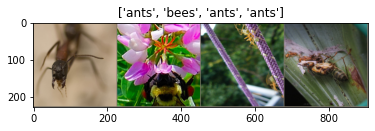

In [5]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

<br>
<br>
<br>

# Training the model <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#training-the-model" style="text-decoration:none;font-size:70%">[link]</a>

<font size=3>Now, let’s write a general function to train a model. Here, we will illustrate:

* Scheduling the learning rate
* Saving the best model

<font color=maroon>In the following, parameter `scheduler` is an **LR scheduler** object from `torch.optim.lr_scheduler`.</font></font>


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)
        
        # each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)   # dim=0 应该是 batch dimension
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == "train":
                scheduler.step()
            
            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

<br>
<br>

## Visualizing the model predictions <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#visualizing-the-model-predictions" style="text-decoration:none;font-size:70%">[link]</a>

Generic function to display predictions for a few images

In [42]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # dim=0是batch dimension，dim=1是与分类概率相关的dimension

            for j in range(inputs.size()[0]): # dim=0是batch dimension
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

<br>
<br>
<br>

# <font color=maroon>**Finetuning**</font> the convnet <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet" style="text-decoration:none;font-size:70%">[link]</a>

Load a pretrained model and reset final fully connected layer.

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

<br>
<br>

##  Train and evaluate <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#train-and-evaluate" style="text-decoration:none;font-size:70%">[link]</a>

It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6473 Acc: 0.6639
val Loss: 0.2623 Acc: 0.8954

Epoch 2/25
----------
train Loss: 0.5194 Acc: 0.7705
val Loss: 0.2769 Acc: 0.9150

Epoch 3/25
----------
train Loss: 0.4509 Acc: 0.8156
val Loss: 0.2505 Acc: 0.9216

Epoch 4/25
----------
train Loss: 0.4189 Acc: 0.7992
val Loss: 0.2743 Acc: 0.8758

Epoch 5/25
----------
train Loss: 0.5178 Acc: 0.8156
val Loss: 0.3722 Acc: 0.8497

Epoch 6/25
----------
train Loss: 0.5445 Acc: 0.7951
val Loss: 0.7042 Acc: 0.7843

Epoch 7/25
----------
train Loss: 0.4827 Acc: 0.7951
val Loss: 0.3403 Acc: 0.8627

Epoch 8/25
----------
train Loss: 0.3492 Acc: 0.8648
val Loss: 0.2567 Acc: 0.8954

Epoch 9/25
----------
train Loss: 0.3513 Acc: 0.8607
val Loss: 0.2887 Acc: 0.8824

Epoch 10/25
----------
train Loss: 0.2737 Acc: 0.8893
val Loss: 0.2454 Acc: 0.9020

Epoch 11/25
----------
train Loss: 0.3919 Acc: 0.8566
val Loss: 0.2421 Acc: 0.9150

Epoch 12/25
----------
train Loss: 0.2827 Acc: 0.8648
val Loss: 0.2469 Acc: 0.9150

E

<br>

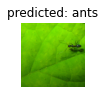

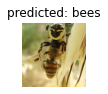

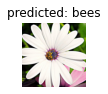

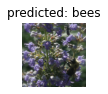

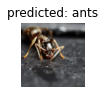

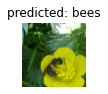

In [43]:
visualize_model(model_ft)

<br>
<br>
<br>

# ConvNet as fixed <font color=maroon>**feature extractor**</font> <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor" style="text-decoration:none;font-size:70%">[link]</a>

<font size=3 color=maroon>Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in `backward()`.</font>

You can read more about this in the documentation <a href="https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward" style="text-decoration:none;color:maroon;font-size:120%;">here</a>.

In [44]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

In [45]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

In [46]:
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

<br>
<br>

## Train and evaluate <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#id1" style="text-decoration:none;font-size:70%">[link]</a>

On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [47]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.6066 Acc: 0.6803
val Loss: 0.4682 Acc: 0.7582

Epoch 2/25
----------
train Loss: 0.4636 Acc: 0.7951
val Loss: 0.1987 Acc: 0.9281

Epoch 3/25
----------
train Loss: 0.5066 Acc: 0.7705
val Loss: 0.2007 Acc: 0.9346

Epoch 4/25
----------
train Loss: 0.3597 Acc: 0.8402
val Loss: 0.1921 Acc: 0.9477

Epoch 5/25
----------
train Loss: 0.4083 Acc: 0.8361
val Loss: 0.1739 Acc: 0.9542

Epoch 6/25
----------
train Loss: 0.4617 Acc: 0.8115
val Loss: 0.1640 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.4692 Acc: 0.7664
val Loss: 0.1684 Acc: 0.9346

Epoch 8/25
----------
train Loss: 0.4114 Acc: 0.8279
val Loss: 0.1621 Acc: 0.9608

Epoch 9/25
----------
train Loss: 0.3276 Acc: 0.8648
val Loss: 0.1551 Acc: 0.9477

Epoch 10/25
----------
train Loss: 0.3761 Acc: 0.8443
val Loss: 0.1939 Acc: 0.9477

Epoch 11/25
----------
train Loss: 0.3002 Acc: 0.8648
val Loss: 0.1576 Acc: 0.9542

Epoch 12/25
----------
train Loss: 0.2884 Acc: 0.8811
val Loss: 0.1683 Acc: 0.9542

E

<br>
<br>

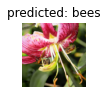

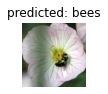

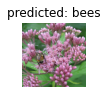

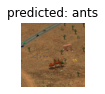

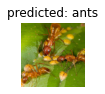

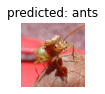

In [48]:
visualize_model(model_conv)

plt.ioff()
plt.show()

<br>
<br>
<br>

# Further Learning <a href="https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#further-learning" style="text-decoration:none;font-size:70%">[link]</a>

<font size=3>If you would like to learn more about the applications of transfer learning, checkout our <a href="" style="text-decoration:none;color:maroon;font-size:120%;">Quantized Transfer Learning for Computer Vision Tutorial</a>.</font>


<br>
<br>

<font style="font-size:120%;LINE-HEIGHT: 30px">
<font color=red><b>代码学习：</b></font><br>

```python

```

</font>

<br>
<br>
<br>